Bunch of imports

In [140]:
%matplotlib inline
import codecs
import re
import numpy as np
import sys
import nltk
import pickle
import random
import copy
from time import time
from functools import wraps
from multiprocessing import Pool
import multiprocessing

Python 3 compatibility

In [141]:
from __future__ import absolute_import
from __future__ import print_function

##Exctract the MedLine data

In [142]:
import tools

In [143]:
def extract_txt(fname):
    t0 = time()
    print("Exctracting from '%s'..."%(fname.split('/')[-1].split('.')[0]))
    sys.stdout.flush()
    s=codecs.open(fname, 'r','utf-8')
    txt = s.read()
    # Use the properties of the Medline abstracts to separate documents
    # Specific to the corpus
    abstracts = re.split(r'PMID.*\n{2,}', txt)
    del abstracts[-1]
    s.close()
    
    duration = time()-t0
    print("%d documents exctracted - %s  [%s/s]" % (len(abstracts), tools.sizeof_h(sys.getsizeof(abstracts)),
                                         tools.sizeof_h(sys.getsizeof(abstracts) / duration)))
    print("Done. [%.02fs]"%(time()-t0))
    
    return abstracts

In [7]:
data = extract_txt('data/reduced_100000.txt')

Exctracting from 'reduced_100000'...
2253 documents exctracted - 18.2KB  [403.6KB/s]
Done. [0.05s]


##Isolate the abstracts

In [144]:
def isolate_labels(subset):
    find = r'(AIM:|AIMS:|[A-Z][-A-Z /\\]{4,}:)'
    labels = re.findall(find,subset,re.MULTILINE)
    return labels

In [145]:
def sub_get_abstracts(subset):
    out=[]
    cmpt=[]
    find = r'.+?(?=\n\n)'
    for idx,pick in enumerate(subset):
        labels = re.finditer(find,pick,re.MULTILINE)
        classes=[]
        while True:
            try:
                res = labels.next()
                classes.append([
                        res.string[res.start():res.end()],
                        res.start(),
                        res.end()
                    ])
            except StopIteration:
                break
    
        leng = len(classes)
        cmpt.append(leng)
        try:
            if leng<5:
                out.append(pick[classes[2][2]+2:classes[3][2]])
                continue
            labels = isolate_labels(pick[classes[3][2]+2:classes[4][2]])
            if len(labels)==0:
                labels = isolate_labels(pick[classes[2][2]+2:classes[3][2]])
            if len(labels)==0:
                labels = isolate_labels(pick[classes[4][2]+2:classes[5][2]])
                if len(labels)==0:
                    labels = isolate_labels(pick[classes[5][2]+2:classes[6][2]])
                    out.append(pick[classes[5][2]+2:classes[6][2]])
                else:
                    out.append(pick[classes[4][2]+2:classes[5][2]])
            else:
                out.append(pick[classes[3][2]+2:classes[4][2]])
        except:
            out.append(pick[classes[2][2]+2:classes[3][2]])
    return out

def get_abstracts(subset,nb_core=multiprocessing.cpu_count()):
    print("Working on %d core..."%(nb_core))
    t0 = time()
    out=[]
    d={}
    results=[]
    pool = Pool(nb_core)

    for x in range(0,nb_core):
        d["tab{0}".format(x)]=[]
        #d["tab%d"%x]=[]
    
    for idx,i in enumerate(subset):
        d['tab%d'%(idx%nb_core)].append(i)
    
    for x in range(0,nb_core):
        ress = pool.apply_async(sub_get_abstracts,[d['tab%d'%(x%nb_core)]])
        results.append(ress)
    
    pool.close()
    pool.join()

    for i in results:
        out.extend(i.get())
        
    print("%s/s on each of the [%d] core" % (tools.sizeof_h((sys.getsizeof(subset)/nb_core)/(time()-t0)),nb_core))
    print("Done. [%.02fs]"%(time()-t0))
    return out

In [10]:
abstracts = get_abstracts(data)

Working on 4 core...
2.1KB/s on each of the [4] core
Done. [2.20s]


In [146]:
def get_err(subset):
    t0 = time()
    cpt=0
    cpt2=0
    list_at_zero=[]
    list_at_one=[]
    list_at_two=[]
    for idx,i in enumerate(subset):
        try:
            iso = isolate_labels(i)
            if len(iso)<3:
                cpt+=1
                if len(iso)==0:
                    cpt2+=1
                    list_at_zero.append(idx)
                elif len(iso)<2:
                    list_at_one.append(idx)
                else:
                    list_at_two.append(idx)
        except:
            list_at_zero.append(idx)
    l1,l2,l3 = len(list_at_zero),len(list_at_one),len(list_at_two)
    """
    print(">Labels found :")
    print("Zero%s"%str(l1).rjust(10,' '))
    print("One %s"%str(l2).rjust(10,' '))
    print("Two %s"%str(l3).rjust(10,' '))
    print("%.01f%% have more than 2 labels [%d/%d]" %(100-(l1+l2+l3)/(len(subset)+0.0)*100,len(subset),(l1+l2+l3)))
    print(">Time : %.04fs" % (time()-t0))
    """
    return list_at_zero,list_at_one,list_at_two

Cleaning, dumping the abstracts with errors, quick and dirty

In [147]:
def remove_err(datas,errs):
    err=sorted([item for subitem in errs for item in subitem],reverse=True)
    for e in err:
        for d in datas:
            del d[e]

In [13]:
remove_err([abstracts],get_err(abstracts))

Replacing numbers with ##NB

In [14]:
find = r'[0-9]+\.[0-9]+|[0-9]+,[0-9]+|[0-9]+'
for idx,i in enumerate(abstracts):
    abstracts[idx] = re.sub(find,r'##NB',i)

Creation of a tokenizer for a correct sentence splitting

In [15]:
try:
    t0 = time()
    print("Loading sentence tokenizer...")
    sys.stdout.flush()
    tokenizer = pickle.load(open("data_processed/tokenizer.pickle", "rb"))
    print("Done. [%.02fs]"%(time()-t0)) 
except (OSError, IOError) as e:
    print("No existing tokenizer, creating one...")
    sys.stdout.flush()
    try:
        y = int(raw_input("Number of articles for the parser training? [Max: %d]\n>"%(len(abstracts))))
        if y<=0 or y>(len(abstracts)):
            raise ValueError
    except ValueError as ve:
        y = len(abstracts)
        print("%s was not understood, using max [%d] instead."%y)
    print("Training tokenizer...")
    sys.stdout.flush()
    t0=time()
    tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()
    text = "\n\n".join(abstracts[0:1000])
    tokenizer.train(text)
    print("Trained. [%.02fs]"%(time()-t0))
    tools.dump_pickle(tokenizer,"data_processed/tokenizer.pickle")

Loading sentence tokenizer...
Done. [0.14s]


In [148]:
def get_sentences_labels(subset):
    find = r'(AIM:|[A-Z][-A-Z /\\]{4,}:)'
    labels = re.finditer(find,subset,re.MULTILINE)
    classes=[]
    while True:
        try:
            res = labels.next()
            classes.append([
                    res.string[res.start():res.end()-1],
                    res.start(),
                    res.end()
                ])
        except StopIteration:
            break
    out = []
    leng = len(subset)
    if len(classes)<2:
        #print "huh"
        #print [classes[0][0],re.sub(r'\n',' ',subset[classes[0][2]+1:])]
        return
    for idx,lab in enumerate(classes):
        if idx == len(classes)-1:
            break
        out.append([
                lab[0],
                tokenizer.sentences_from_text(re.sub(r'\n',' ',subset[lab[2]+1:classes[idx+1][1]]))
                ])
    out.append([
            lab[0],
            tokenizer.sentences_from_text(re.sub(r'\n',' ',subset[classes[-1][2]+1:leng]))
            ])
    return out

In [149]:
def interm(subset):
        res = []
        for i in subset:
            tmp = get_sentences_labels(i)
            res.append(tmp)
        return res

In [150]:
def ex_all_labels(subset,nb_core=multiprocessing.cpu_count()):
    print("Working on %d core..."%(nb_core))
    sys.stdout.flush()
    t0 = time()
    out=[]
    d={}
    results=[]
    pool = Pool(nb_core)

    for x in range(0,nb_core):
        d["tab{0}".format(x)]=[]
        #d["tab%d"%x]=[]
    
    for idx,i in enumerate(subset):
        d['tab%d'%(idx%nb_core)].append(i)
    
    for x in range(0,nb_core):
        ress = pool.apply_async(interm,[d['tab%d'%(x%nb_core)]])
        results.append(ress)
    
    pool.close()
    pool.join()

    for i in results:
        out.extend(i.get())
        
    print("%s/s on each of the [%d] core" % (tools.sizeof_h((sys.getsizeof(subset)/nb_core)/(time()-t0)),nb_core))
    print("Done. [%.02fs]"%(time()-t0))
    return out

In [19]:
abstracts_labeled = ex_all_labels(abstracts)

Working on 4 core...
4.7KB/s on each of the [4] core
Done. [1.07s]


##Lemmatization and special imports

In [21]:
from textblob import Word
#from textblob import TextBlob
from textblob import Blobber
from textblob_aptagger import PerceptronTagger

In [22]:
def sub_lemm(subset):
    suba = []
    tb = Blobber(pos_tagger=PerceptronTagger())
    for abst in subset:
        t_a=[]
        for labl in abst:
            t_l=[]
            for t in labl[1]:
                tag = tb(t.lower()).tags
                ph_out=[]
                for i in tag:
                    if i[1][0]=='V':
                        ph_out.append(Word(i[0]).lemmatize('v'))
                    elif i[1][0]=='N':
                        ph_out.append(Word(i[0]).lemmatize('n'))
                    else:
                        ph_out.append(i[0])
                #print "LEM",time()-t1
                t_l.append(' '.join(ph_out))
            t_a.append([labl[0],t_l])
        suba.append(t_a)
    return suba

In [23]:
def lemm(subset,show_time=True,nb_core=multiprocessing.cpu_count()):
    print("Working on %d core..."%(nb_core))
    print("Splitting datas...",end=" ")
    sys.stdout.flush()
    out=[]
    d={}
    results=[]
    pool = Pool(nb_core)
    
    for x in range(0,nb_core):
        d["tab{0}".format(x)]=[]
        #d["tab%d"%x]=[]

    for idx,i in enumerate(subset):
        d['tab%d'%(idx%nb_core)].append(i)

    t0 = time()
    for x in range(0,nb_core):
        ress = pool.apply_async(sub_lemm,[d['tab%d'%(x%nb_core)]])
        results.append(ress)
    print("Done. [%.02fs]"%(time()-t0))
    print("Lemmatizing...")
    sys.stdout.flush() 
    t0 = time()
    pool.close()
    pool.join()
    for i in results:
        out.extend(i.get())
    print("Done. [%.02fs]"%(time()-t0))
    return out

In [24]:
lemmatized = lemm(abstracts_labeled)

Working on 4 core...
Splitting datas... Done. [0.00s]
Lemmatizing...
Done. [43.62s]


In [ ]:
#lemmatized = tools.load_pickle("data/name.pickle")

###Label analysis
*Does not affect the corpus*

In [30]:
def create_dic_simple(subset_o):
    t0 = time()
    print("Creating dictionary of labels...")
    subset = copy.deepcopy(subset_o)
    sys.stdout.flush()
    dic = {}
    def add_dic(s,t):
        try:
            dic[s][0] += 1
            dic[s][1] += t
        except KeyError:
            dic[s] = [1,t]
    for idx, i in enumerate(subset):
        for j in i:
            add_dic(j[0],j[1])
    print("Done. [%.02fs]"%(time()-t0))
    return dic

In [151]:
def show_keys(dic,threshold=5000):
    w = []
    for i in dic.keys():
        w.append([i,dic[i][0]])
    w.sort(key=lambda x: x[1],reverse=True)
    for idx,i in enumerate(w):
        if i[1]>=threshold:
            print(str(i[1]).ljust(9,"_")+i[0])
        else:   
            print("...\n(%d other labels with less than %d occurences)\n..."%(len(w)-idx,threshold))
            break

In [152]:
def regroup_keys(dic,primary_keyword):
    cpt=0
    for j in primary_keyword:
        for i in dic.keys():
            if i != j and (str(i).find(j) != -1):
                try:
                    cpt+=1
                    dic[j][0]+=dic[i][0]
                    dic[j][1]+=dic[i][1]
                    del dic[i]
                except KeyError:
                    dic[j]=[dic[i][0],dic[i][1]]
                    del dic[i]
                    pass
    print("Keys regrouped:",cpt)

In [153]:
def replace_keys(dic, keys_to_replace, replace_with):
    cpt=0
    for idx,jj in enumerate(keys_to_replace):
        for j in jj:  
            try:
                dic[replace_with[idx]][0]+=dic[j][0]
                dic[replace_with[idx]][1]+=dic[j][1]
                del dic[j]
                cpt+=1
            except KeyError:
                try:
                    dic[replace_with[idx]]=[dic[j][0],dic[j][1]]
                    del dic[j]
                    cpt+=1
                except KeyError:
                    pass
    print("Keys regplaced:",cpt)

In [39]:
dic = create_dic_simple(lemmatized)

Creating dictionary of labels...
Done. [0.12s]


In [52]:
print("Number of labels :",len(dic.keys()))
show_keys(dic,threshold=100)

Number of labels : 201
1945_____RESULTS
1434_____METHODS
1253_____BACKGROUND
1065_____CONCLUSION
1011_____CONCLUSIONS
384______OBJECTIVE
183______INTRODUCTION
179______MATERIALS AND METHODS
145______PURPOSE
142______OBJECTIVES
111______AIM
...
(190 other labels with less than 100 occurences)
...


In [53]:
primary_keyword=['AIM','BACKGROUND','METHOD','RESULT','CONCLUSION','OBJECTIVE','DESIGN','FINDINGS','OUTCOME','PURPOSE']

In [54]:
regroup_keys(dic,primary_keyword)

Keys regrouped: 97


In [56]:
show_keys(dic,threshold=100)

2117_____CONCLUSION
1985_____RESULT
1918_____METHOD
1285_____BACKGROUND
531______OBJECTIVE
183______INTRODUCTION
179______AIM
145______PURPOSE
...
(97 other labels with less than 100 occurences)
...


In [57]:
keys_to_replace = [['INTRODUCTION'],
                   ['AIM','PURPOSE'],
                   ['CONTEXT']]

replace_with =    ['BACKGROUND',
                   'OBJECTIVE',
                   'BACKGROUND']

In [58]:
replace_keys(dic,keys_to_replace,replace_with)

Keys regplaced: 4


In [60]:
show_keys(dic,threshold=100)

2117_____CONCLUSION
1985_____RESULT
1918_____METHOD
1475_____BACKGROUND
855______OBJECTIVE
...
(96 other labels with less than 100 occurences)
...


###Choosing labels

In [154]:
def get_exactly(subset,
             pattern=[['BACKGROUND','BACKGROUNDS'],
                             ['METHOD','METHODS'],
                             ['RESULT','RESULTS'],
                             ['CONCLUSION','CONCLUSIONS']],
             no_truncate=False):
    t0 = time()
    print("Selecting abstracts...")
    sys.stdout.flush()
    sub_perfect=[]
    for i in subset:
        match=True
        try:
            for idx,j in enumerate(pattern):
                if not i[idx][0] in j:
                    match=False
                    break
            if match:
                if not no_truncate:
                    sub_perfect.append(i[:len(pattern)])
                else:
                    if len(i)==len(pattern):
                        sub_perfect.append(i[:len(pattern)])
        except:
            pass
    cpt=float(len(sub_perfect))
    print("%d/%d match the pattern (%d%%)" %(cpt,len(subset),int((cpt/len(subset))*100)))
    print("Done. [%.02fs]"%(time()-t0))
    return sub_perfect

In [155]:
pattern = [
    ['BACKGROUND','BACKGROUNDS','OBJECTIVE'],
    ['METHOD','METHODS'],
    ['RESULT','RESULTS'],
    ['CONCLUSION','CONCLUSIONS']
]

In [70]:
sub_perfect = get_exactly(lemmatized,pattern=pattern,no_truncate=False)

Selecting abstracts...
901/2201 match the pattern (40%)
Done. [0.06s]


In [71]:
print("%d abstracts labeled and ready for the next part!"%len(sub_perfect))

901 abstracts labeled and ready for the next part!


##Preparing the data for the classifier

In [156]:
# %matplotlib inline
import logging
from optparse import OptionParser
from time import time
import matplotlib.pyplot as plt

#from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction import DictVectorizer
#from sklearn.feature_extraction.text import HashingVectorizer
#from sklearn.feature_selection import SelectKBest, chi2
#from sklearn.linear_model import RidgeClassifier
#from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
#from sklearn.linear_model import SGDClassifier
#from sklearn.linear_model import Perceptron
#from sklearn.linear_model import PassiveAggressiveClassifier
#from sklearn.naive_bayes import BernoulliNB, MultinomialNB
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.neighbors import NearestCentroid
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.utils.extmath import density
from sklearn import metrics

from sklearn.metrics import confusion_matrix
#from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.ensemble import AdaBoostClassifier




In [157]:
def create_dic(subset,nb_index):
    t0 = time()
    print("Creating dictionary of labels...")
    sys.stdout.flush()
    dic = {}
    # remove the copy when a better solution is found
    stt = copy.deepcopy(subset)
    for idx, i in enumerate(stt):
        cpt=0.0
        for x in i:
            cpt+=len(x[1])
        cc=0
        for j in i:
            tmp=[]
            for smt in j[1]:
                tmp.append("##LEN%s ##POS%s ##IDX%s %s"%(cpt,cc,str(int((cc/cpt)*nb_index)),smt))
                cc+=1
            try:
                dic[j[0]][0] += 1
                dic[j[0]][1] += tmp
            except KeyError:
                dic[j[0]] = [1,tmp]
    print("Done. [%.02fs]"%(time()-t0))
    return dic

In [74]:
dic = create_dic(sub_perfect,100)

Creating dictionary of labels...
Done. [0.09s]


In [75]:
primary_keyword=['AIM','BACKGROUND','METHOD','RESULT','CONCLUSION','OBJECTIVE','DESIGN','FINDINGS','OUTCOME','PURPOSE']
regroup_keys(dic,primary_keyword)

Keys regrouped: 3


In [76]:
keys_to_replace = [['HUM','SOMETHING'],
                   ['OUTCOME'],
                   ['CONTEXT']]

replace_with =    ['BACKGROUND',
                   'FINDINGS',
                   'BACKGROUND']

replace_keys(dic,keys_to_replace,replace_with)

Keys regplaced: 0


In [77]:
print("Sentences per label :",["%s %d"%(s,len(dic[s][1])) for s in dic.keys()])

Sentences per label : [u'RESULT 3885', u'BACKGROUND 1872', u'OBJECTIVE 335', u'METHOD 2866', u'CONCLUSION 1803']


###Creating train and test data

In [158]:
np.random.seed(1337)  # for reproducibility
random.seed(1337)

In [79]:
# classes to use a classifier onto
#classes_names=['BACKGROUND','METHOD','RESULT','CONCLUSION']
classes_names = dic.keys()
dic.keys()

[u'RESULT', u'BACKGROUND', u'OBJECTIVE', u'METHOD', u'CONCLUSION']

In [159]:
def split_data(dic,classes_names,split_train_test = 0.8,truncate=-1):
    classes=[]
    tmp_x=[]
    tmp_y=[]
    
    def _vect_label(n,nb):
        tmp = np.zeros(nb)
        tmp[n] = 1
        return tmp
    
    if truncate<0:
        truncate = min(len(dic[e][1]) for e in classes_names)
        
    for idx,c in enumerate(classes_names):
        classes.append(idx)
        tmp_x.extend(dic[c][1][:truncate])
        tmp_y.extend(np.tile(_vect_label(idx,len(classes_names)),(truncate,1)))

    x_shuf = []
    y_shuf = []
    
    index_shuf = range(len(tmp_y))
    random.shuffle(index_shuf)
    for i in index_shuf:
        x_shuf.append(tmp_x[i])
        y_shuf.append(tmp_y[i])

    sp = int(len(y_shuf)*split_train_test)
    raw_x_train,raw_x_test = x_shuf[:sp],x_shuf[sp:]
    raw_y_train,raw_y_test = y_shuf[:sp],y_shuf[sp:]
    return raw_x_train, raw_y_train, raw_x_test, raw_y_test

In [81]:
# train/test split
split = 0.8

# truncate the number of abstracts to consider for each label,
# -1 to set to the maximum while keeping the number of sentences per labels equal
truncate = -1

raw_x_train, raw_y_train, raw_x_test, raw_y_test = split_data(dic,classes_names,
                                                              split_train_test=split,
                                                              truncate=-1)

Vectorizing

In [82]:
vectorizer = TfidfVectorizer(sublinear_tf=True,
                             min_df=0.0000005,
                             ngram_range=(1,1),
                             stop_words='english',
                             token_pattern=r'[a-z0-9#]{2,}')

In [83]:
def vectorize_data(vectorizer, raw_x_train, raw_y_train, raw_x_test, raw_y_test):
    t0 = time()
    
    print("Vectorizing the training set...",end=""); sys.stdout.flush()
    vectorizer.fit(raw_x_train)
    print("Done. [%.02fs]"%(time()-t0)); sys.stdout.flush()
    
    #print("Vectorizing the training set...",end=""); sys.stdout.flush()
    #i_tmp_X_train = vectorizer.fit_transform(raw_x_train)
    #print("Done. [%.02fs]"%(time()-t0)); sys.stdout.flush()
    
    #t1 = time()
    #print("Vectorizing the testing set...",end=""); sys.stdout.flush()
    #i_tmp_X_test = vectorizer.transform(raw_x_test)
    #print("Done. [%.02fs]"%(time()-t1)); sys.stdout.flush()
    
    t2 = time()
    print("Getting features...",end=""); sys.stdout.flush()
    feature_names = vectorizer.get_feature_names()
    print("Done. [%.02fs]"%(time()-t2)); sys.stdout.flush()
    
    tmp_y_train = raw_y_train
    tmp_y_test = raw_y_test
    
    t3 = time()
    print("Creating order...",end=""); sys.stdout.flush()
    tmp_dic={}
    max_features = len(vectorizer.vocabulary_) + 1
    for idx, i in enumerate(feature_names):
        tmp_dic[i]=idx+1
        
    tmp_X_train = []
    c = re.compile(r'[a-z0-9#]{2,}')
    for i in range(len(raw_x_train)):
        l = c.findall(raw_x_train[i].lower())
        x = []
        for i in l:
            try:
                x.append(tmp_dic[i])
            except KeyError:
                pass
        tmp_X_train.append(x)

    tmp_X_test = []

    for i in range(len(raw_x_test)):
        l = c.findall(raw_x_test[i].lower())
        x = []
        for i in l:
            try:
                x.append(tmp_dic[i])
            except KeyError:
                pass
        tmp_X_test.append(x)
    print("Done. [%.02fs]"%(time()-t3)); sys.stdout.flush()
       
    print("Done. [%.02fs]"%(time()-t0))
    return tmp_X_train, tmp_y_train, tmp_X_test, tmp_y_test, feature_names, max_features
    

In [84]:
X_train, y_train, X_test, y_test, feature_names, max_features = vectorize_data(vectorizer,raw_x_train, raw_y_train, raw_x_test, raw_y_test)

Vectorizing the training set...Done. [0.07s]
Getting features...Done. [0.00s]
Creating order...Done. [0.05s]
Done. [0.13s]


##Training a neural network

imports

In [163]:
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adagrad, Adam
#from keras.utils import np_utils
from keras.models import Sequential
#from keras.layers.core import Dense, Dropout, Activation
from keras.layers.core import *
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU, JZS1
from keras.callbacks import *

#import seaborn as sns
import seaborn.apionly as sns


from sklearn.metrics import confusion_matrix

Adapt the data for a LSTM network

In [86]:
print("Pad sequences (samples x time)")
sys.stdout.flush()
X_train = sequence.pad_sequences(X_train, maxlen=40)
X_test = sequence.pad_sequences(X_test, maxlen=40)
y_train = np.array(y_train)
y_test = np.array(y_test)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Pad sequences (samples x time)
X_train shape: (1340, 40)
X_test shape: (335, 40)


In [162]:
X_train, y_train, X_test, y_test, feature_names, max_features, classes_names, vectorizer = tools.load_pickle("XyXyfmcv.pickle")

Loading 'XyXyfmcv.pickle'...
Done. [2.00s]


Creating the network

In [164]:
%%time
dim_out = len(classes_names)

print('Building model...')
sys.stdout.flush()
net = Sequential()
net.add(Embedding(max_features, 256))
net.add(LSTM(256, 256))
net.add(Dropout(0.5))
net.add(Dense(256, dim_out))
net.add(Activation('softmax'))
net.compile(loss='categorical_crossentropy', optimizer='adam', class_mode="categorical")

Building model...
CPU times: user 53.8 s, sys: 1.42 s, total: 55.2 s
Wall time: 55.3 s


In [167]:
len(X_test)

98296

Training the network

In [166]:
def train_network(network,
                  X_train,y_train,X_test,y_test,
                  epoch,
                  batch_size=64,path_save="/tmp/weights.hdf5"):
    #t0=time()
    print("Training...")
    sys.stdout.flush()

    class LossHistory(Callback):
        def on_train_begin(self, logs={}):
            self.losses = []
            self.accuracy = []
            self.val_losses = []
            self.val_accuracy = []
            self.metric = []

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
            self.accuracy.append(logs.get('acc'))
            
        def on_epoch_end(self, epoch, logs={}):
            self.val_losses.append(logs.get('val_loss'))
            self.val_accuracy.append(logs.get('val_acc'))
            self.metric.append(self.val_accuracy[-1]-(self.val_losses[-1]/10.))
            if len(self.val_accuracy)<2:
                network.save_weights(path_save,overwrite=True)
                print("Saving at first epoch")
            else:
                tmp = True
                for i in self.metric[:-1]:
                    if self.metric[-1]<i:
                        tmp = False
                        break
                if tmp:
                    network.save_weights(path_save,overwrite=True)
                    print("Model improved, saving weight")

    history = LossHistory()
    earlystop = EarlyStopping(monitor='val_acc', patience=2, verbose=1)
    #checkpoint = ModelCheckpoint(filepath=path_save, verbose=1, save_best_only=True)


    network.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epoch,
                validation_data=(X_test, y_test), show_accuracy=True, callbacks=[history,earlystop])
    #score, acc = network.evaluate(X_test, y_test, batch_size=batch_size, show_accuracy=True)
    #print('Test score:', score)
    #print('Test accuracy:', acc)
    #print(history.losses)
    network.load_weights(path_save)
    return history

In [168]:
history = train_network(net,
                          X_train[:20000],y_train[:20000],X_test[:20000],y_test[:20000],
                          20,
                          batch_size=64,path_save="/tmp/weights.hdf5")

Training...
Train on 20000 samples, validate on 20000 samples
Epoch 0
20000/20000 [==============================] - 454s - loss: 0.7760 - acc: 0.6437 - val_loss: 0.5696 - val_acc: 0.7288
Saving at first epoch
Epoch 1
20000/20000 [==============================] - 451s - loss: 0.4440 - acc: 0.7978 - val_loss: 0.5099 - val_acc: 0.7687
Model improved, saving weight
Epoch 2
20000/20000 [==============================] - 450s - loss: 0.3176 - acc: 0.8695 - val_loss: 0.5342 - val_acc: 0.7718
Model improved, saving weight
Epoch 3
20000/20000 [==============================] - 452s - loss: 0.2196 - acc: 0.9181 - val_loss: 0.6250 - val_acc: 0.7602
Epoch 00003: early stopping


##Evaluate the network

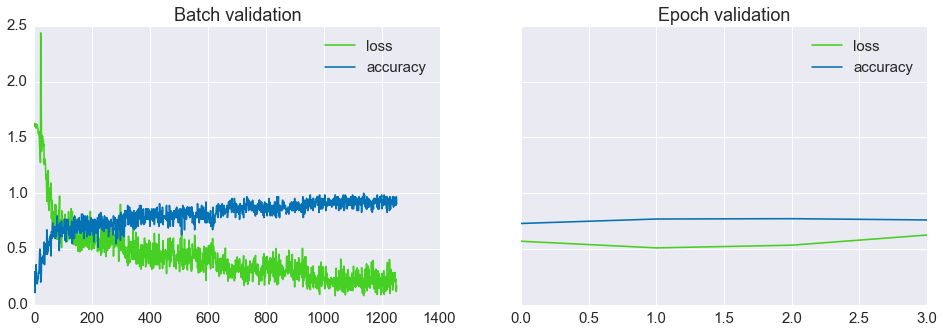

In [169]:
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.6})
sns.mpl.rc("figure", figsize=(16,5))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(history.losses, color="#47d024")
ax1.plot(history.accuracy, color="#0672b6")
ax1.legend(["loss","accuracy"])
ax1.set_title("Batch validation")

ax2.plot(history.val_losses, color="#47d024")
ax2.plot(history.val_accuracy, color="#0672b6")
ax2.legend(["loss","accuracy"])
ax2.set_title("Epoch validation")

plt.show()

In [170]:
def evaluate_network(network, X_test, y_test):
    resp = network.predict_proba(X_test,batch_size=16,verbose=False)
    resc = network.predict_classes(X_test,batch_size=16,verbose=False)

    a1=[]
    a2=[]
    cpt=0
    cpt_on=[]
    cpt_real=[]
    cpt_should=0
    should=[]
    cpt_shouldnt=0
    shouldnt=[]
    for idx, i in enumerate(resc):
        a1.append(i)
        a2.append(np.array(y_test[idx]).argmax())
        if i.tolist()==[0,0,0,0]:
            cpt+=1
            cpt_on.append(resp[idx].argmax())
            cpt_real.append(np.array(y_test[idx]).argmax())
            if cpt_on[-1]==cpt_real[-1]:
                cpt_should+=1
                should.append(resp[idx].argmax())
            else:
                cpt_shouldnt+=1
                shouldnt.append(resp[idx].argmax())
            #print(resp[idx])
    print("No decision: %d / %d  [%.02f%%]"%(cpt,len(resc),
                                          (cpt/float(len(resc)))*100 ) , end="")
    print(cpt_should,cpt_shouldnt)
    
    print("Accuracy: %.06f"%metrics.label_ranking_average_precision_score(y_test,resp))
    
    cpt_on = np.array(cpt_on)
    print(metrics.classification_report(a1,a2,target_names=classes_names))
    
    print("Confusion matrix:")
    cm = confusion_matrix(a1, a2)
    print(cm)
    sns.set_style("ticks")
    sns.mpl.rc("figure", figsize=(8,4))

    #ax1.get_yaxis().set_tick_params(which='both', direction='out')
    #ax1.get_xaxis().set_tick_params(which='both', direction='out')

    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig = plt.figure()
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes_names))
    plt.xticks(tick_marks, classes_names, rotation=45)
    plt.yticks(tick_marks, classes_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tick_params(which='both', direction='in',length=0)
    plt.show()
    return a1,a2

No decision: 0 / 98296  [0.00%]0 0
Accuracy: 0.881743
             precision    recall  f1-score   support

     RESULT       0.78      0.87      0.82     17311
 BACKGROUND       0.65      0.63      0.64     20100
  OBJECTIVE       0.63      0.66      0.65     18923
     METHOD       0.87      0.81      0.84     21346
 CONCLUSION       0.95      0.90      0.92     20616

avg / total       0.78      0.77      0.78     98296

Confusion matrix:
[[15147    39    36  1150   939]
 [   77 12731  6353   936     3]
 [   21  5916 12504   477     5]
 [ 2303   968   848 17197    30]
 [ 1969    17     8    44 18578]]


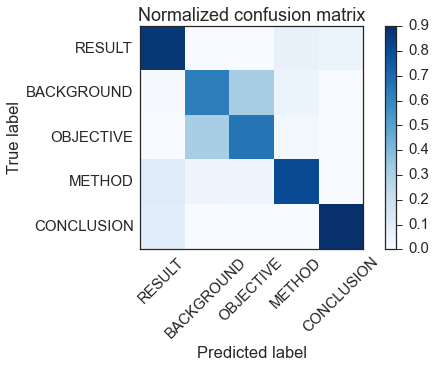

In [171]:
# white, dark, whitegrid, darkgrid, ticks
a1,a2=evaluate_network(net, X_test[:20000], y_test[:20000])

##Predict on a new corpus

In [137]:
t = np.array([random.choice(range(X_test.shape[0]))])
corr = classes_names
print(classes_names)
print(t)
print(y_test[t])

print("Correct >>",corr[ np.array(y_test[t]).argmax() ])
x = X_test[t]

pred = net.predict_proba(x, batch_size=32,verbose=False)[0]
print("Predict >>",corr[ pred.argmax() ])
print(net.predict_classes(x, batch_size=32,verbose=False))
print(pred)


print()
for i in x.tolist()[0]:
    if i!=0:
        print(feature_names[i])

[u'RESULT', u'BACKGROUND', u'OBJECTIVE', u'METHOD', u'CONCLUSION']
[36]
[[ 0.  0.  0.  0.  1.]]
Correct >> CONCLUSION
Predict >> CONCLUSION
[4]
[  2.00e-03   8.43e-04   4.14e-04   5.32e-04   9.96e-01]

##len12
aa
##idx82
childbirth
contain
session
province
recent
informative
individualised
follower
needle
established


In [139]:
tools.show_colors(dic)

RESULT          BACKGROUND      OBJECTIVE       METHOD          CONCLUSION      
RESULT          BACKGROUND      OBJECTIVE       METHOD          CONCLUSION      

In [ ]:
def network_predict_labeled(network,lab):
    cc=0
    for i in lab:
        #print '-'*80
        #print i[0]
        #print '^'*80
        #['METHOD','RESULT','CONCLUSION','BACKGROUND']
        d={'METHOD':2,'RESULT':3,'CONCLUSION':6,'BACKGROUND':5}
        cpt=0.0
        for x in lab:
            cpt+=len(x[1])
        tmp=[]
        for smt in i[1]:
            tmp.append("##IDX%s %s"%(str(int((cc/cpt)*NB_INDEX)),smt))
            cc+=1
        for j in tmp:
            confidence,predd = get_prediction(j)
            j=j[7:]
            if i[0]!=predd:
                print("\x1b[4%dm%s\x1b[0m [Confidence: %.02f] \x1b[41mdifferent\x1b[0m\n\x1b[4%dm%s\x1b[0m\n"%(d[i[0]],i[0].ljust(10),confidence,d[predd],j)) 
            else:
                print("\x1b[4%dm%s\x1b[0m [Confidence: %.02f]\n\x1b[4%dm%s\x1b[0m\n"%(d[i[0]],i[0].ljust(10),confidence,d[predd],j))
        